<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Convolutional Neural Network (CNN)

이번 과제에서는 CNN(Convolutional Neural Network)을 사용해서 MNIST classification을 구현합니다. 밑바닥부터 구현하는 것은 아니고 "FILL IN HERE" 부분을 채우면 됩니다. 지워진 부분을 찾아서 코드를 작성한 후 실행해보세요.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.10.0+cu111].
device:[cuda:0].


### Dataset

Dataset은 [기본 과제] MLP Assignment에서 사용했던 MNIST입니다.

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [5]:
xdim=[1,28,28]
xdim[1]

28

In [7]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    def __init__(self,name='cnn',xdim=[1,28,28],
                 ksize=3,cdims=[32,64],hdims=[1024,128],ydim=10,
                 USE_BATCHNORM=False):
        super(ConvolutionalNeuralNetworkClass,self).__init__()
        self.name = name

        self.xdim = xdim

        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims

        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM

        # Convolutional layers
        self.layers = []
        prev_cdim = self.xdim[0]

        # 처음에는 32로 그 다음에는 64로
        for cdim in self.cdims: # for each hidden layer
            self.layers.append(
                nn.Conv2d(
                    # FILL IN HERE
                    in_channels=prev_cdim,
                    out_channels=cdim,
                    kernel_size=self.ksize,
                    stride=(1,1),
                    padding=self.ksize//2
                ) # convlution 
            )
            # 배치놈
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm

            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling
            # 반씩 줄여 맥스풀링 
            self.layers.append(nn.Dropout2d(p=0.5))  # dropout
            prev_cdim = cdim

        # Dense layers
        self.layers.append(nn.Flatten())
        # 한 줄로 핀다 64 * 7 * 7

        # 한 줄로 폈을 때 길이 64 * 7 * 7
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))

        for hdim in self.hdims:
          # 한줄을 1024 128 순으로 선형
            self.layers.append(nn.Linear(
                # FILL IN HERE
                prev_hdim,hdim,bias=True
                               ))
            self.layers.append(nn.ReLU(True))  # activation
            prev_hdim = hdim
             
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers 
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            # 쌓아논 layers 들을 sequential에 정리
            self.net.add_module(layer_name,layer)
            # add_module의 장점 : 이름을 정의 할 수 있다는 점

        self.init_param() # initialize parameters
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
    def forward(self,x):
        return self.net(x)

C = ConvolutionalNeuralNetworkClass(
    name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],
    hdims=[32],ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(),lr=1e-3)
print ("Done.")

Done.


### Check Parameters

In [8]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[-0.216  0.516 -0.543  0.07   0.142]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[-0.026 -0.032 -0.116 -0.016 -0.092]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[-0.025  0.023  0.015  0.014  0.04 ]
[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[-0.043  0.015 -0.068 -0.224  0.303]
[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[119,530].


### Simple Forward Path of the CNN Model

In [9]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)

x_numpy = np.random.rand(2,1,28,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array

print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.652, 0.307, 0.271,  ..., 0.990, 0.130, 0.583],
          [0.272, 0.086, 0.052,  ..., 0.888, 0.957, 0.642],
          [0.034, 0.418, 0.145,  ..., 0.620, 0.395, 0.917],
          ...,
          [0.368, 0.650, 0.341,  ..., 0.855, 0.187, 0.204],
          [0.226, 0.147, 0.500,  ..., 0.907, 0.396, 0.287],
          [0.513, 0.014, 0.669,  ..., 0.590, 0.881, 0.500]]],


        [[[0.152, 0.012, 0.019,  ..., 0.238, 0.557, 0.417],
          [0.339, 0.982, 0.848,  ..., 0.808, 0.768, 0.667],
          [0.882, 0.583, 0.268,  ..., 0.361, 0.976, 0.092],
          ...,
          [0.435, 0.350, 0.352,  ..., 0.232, 0.626, 0.702],
          [0.547, 0.356, 0.864,  ..., 0.956, 0.922, 0.471],
          [0.818, 0.980, 0.991,  ..., 0.746, 0.385, 0.770]]]], device='cuda:0')
y_torch:
 tensor([[ 6.190, -1.779, -2.620,  0.313, -3.966,  0.022,  2.730,  7.350, -1.591,
          1.917],
        [ 1.335, -0.242, -1.332,  1.667,  1.262, -1.111,  2.102,  0.600,  1.448,
         -4.942]], device=

### Evaluation Function

In [10]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [11]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.061] test_accr:[0.059].


### Train

In [12]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode 
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        # FILL IN HERE      # reset gradient 
        optm.zero_grad()
        # FILL IN HERE      # backpropagate
        loss_out.backward()
        # FILL IN HERE      # optimizer update
        optm.step()
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device)
        test_accr = func_eval(C,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.485] train_accr:[0.957] test_accr:[0.959].
epoch:[1] loss:[0.170] train_accr:[0.973] test_accr:[0.975].
epoch:[2] loss:[0.121] train_accr:[0.982] test_accr:[0.981].
epoch:[3] loss:[0.100] train_accr:[0.984] test_accr:[0.984].
epoch:[4] loss:[0.086] train_accr:[0.986] test_accr:[0.987].
epoch:[5] loss:[0.077] train_accr:[0.989] test_accr:[0.987].
epoch:[6] loss:[0.070] train_accr:[0.989] test_accr:[0.987].
epoch:[7] loss:[0.064] train_accr:[0.990] test_accr:[0.989].
epoch:[8] loss:[0.059] train_accr:[0.991] test_accr:[0.987].
epoch:[9] loss:[0.058] train_accr:[0.991] test_accr:[0.988].
Done


### Test

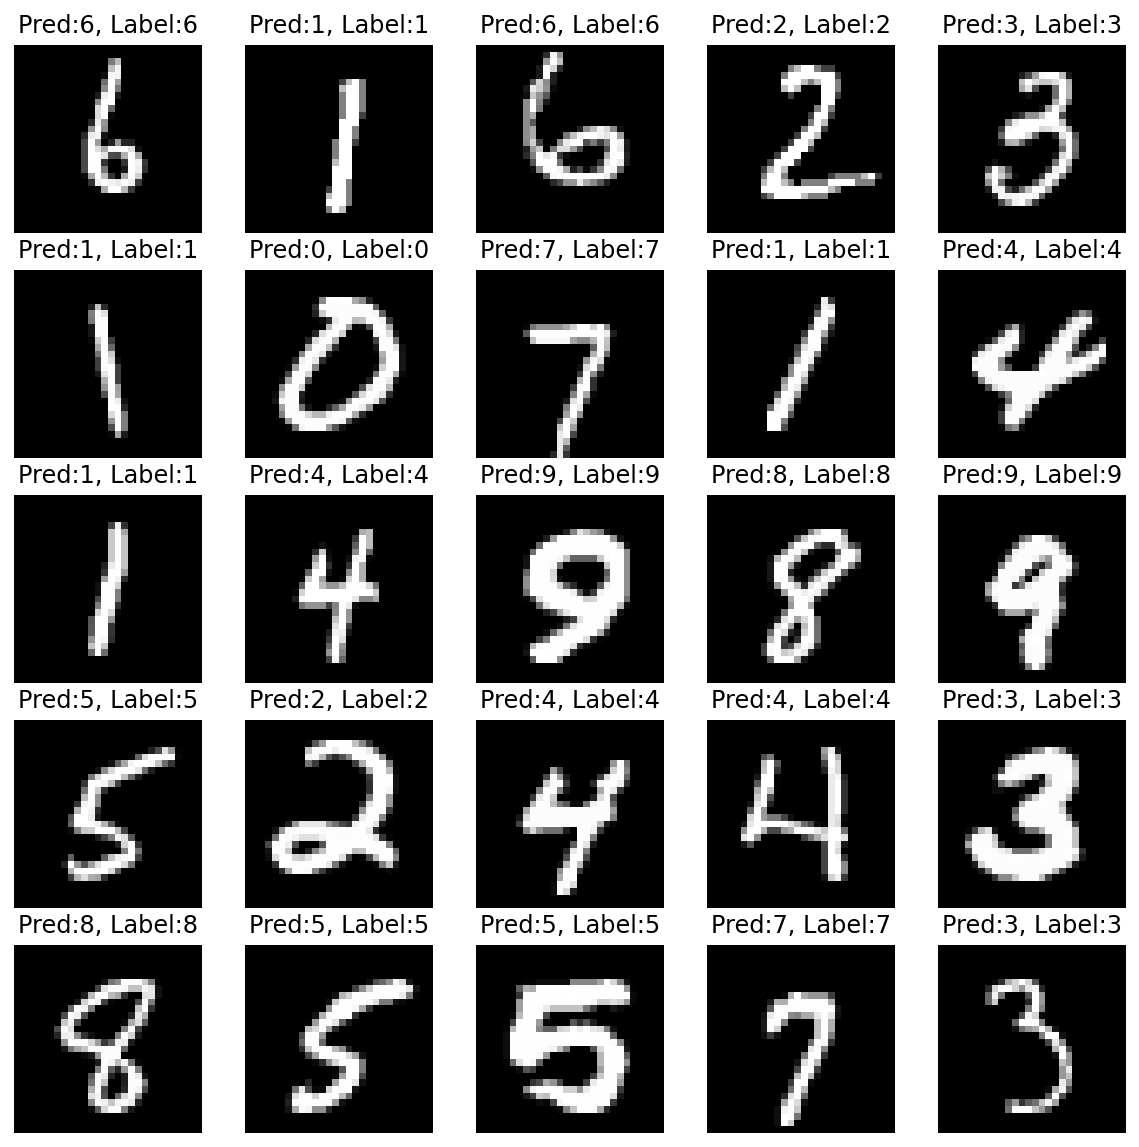

Done


In [13]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval() # to evaluation mode 
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")

In [ ]:
# train 할때와 test 할때 모드 변경이 꼭 필요